In [1]:
#Tasks:

#1. Test an easy GNN
#2. Test Schnet
# Compare results on different systems but also within the same system
# Compare results based on node predicton and graph prediction
#Write out the architecture of the GNNs used


#Implement atomic number embedding for Fe and Gd
#Implemnt the total energy for the system as target property


#Use Schnet to produce benchmark reults for FeGd system
#Test both energy and magnetic moment predictions

In [1]:
#Test class for data loading
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset

dataset_train = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
    )

dataset_val = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[6],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
    )

dataset_test = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[7],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
    )

# Apply to loaded datasets
dataset_test[0]


Loading systems: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Data(x=[800, 5], edge_index=[2, 9168], edge_attr=[9168, 4], y=[800, 3], pos=[800, 3], system_id=7, timestep=0)

In [ ]:
import torch
import numpy as np


# ---------- STATS ----------

def compute_normalization_stats(dataset):
    """
    Spins (x[:,2:5]) -> mean/std
    B-field (y)      -> log-magnitude + mean/std
    """
    # collect over whole dataset
    all_spins = torch.cat([d.x[:, 2:5] for d in dataset], dim=0)   # [N,3]
    all_B     = torch.cat([d.y          for d in dataset], dim=0)  # [N,3]

    # spins: normal standardization
    moment_mean = all_spins.mean(dim=0)
    moment_std  = all_spins.std(dim=0).clamp(min=1e-6)

    # B: log-magnitude transform for each component separately
    B_abs = all_B.abs()
    # scale parameter ~ typical magnitude
    B_s0  = torch.quantile(B_abs, 0.5, dim=0)  # median |B|
    B_s0  = B_s0.clamp(min=1.0)                # avoid tiny scale

    B_log = all_B.sign() * torch.log1p(B_abs / B_s0)

    B_log_mean = B_log.mean(dim=0)
    B_log_std  = B_log.std(dim=0).clamp(min=1e-6)

    stats = {
        "moment_mean": moment_mean,
        "moment_std":  moment_std,
        "B_s0":        B_s0,
        "B_log_mean":  B_log_mean,
        "B_log_std":   B_log_std,
    }
    return stats


# ---------- NORMALIZE ONE GRAPH ----------

def normalize_graph(data, stats):
    """
    Return a normalized copy of a PyG Data object.
    Spins: (x[:,2:5] - mean) / std
    B:     sign(B)*log1p(|B|/s0), then standardize
    """
    d = data.clone()

    # spins
    d.x[:, 2:5] = (d.x[:, 2:5] - stats["moment_mean"]) / stats["moment_std"]
    

    # B -> log space
    B     = d.y
    B_s0  = stats["B_s0"].to(B.device)
    B_abs = B.abs()
    B_log = B.sign() * torch.log1p(B_abs / B_s0)

    # standardize log-B
    B_log_mean = stats["B_log_mean"].to(B.device)
    B_log_std  = stats["B_log_std"].to(B.device)
    d.y = (B_log - B_log_mean) / B_log_std

    return d


# ---------- NORMALIZE DATASET ----------

def normalize_dataset(dataset, stats):
    return [normalize_graph(d, stats) for d in dataset]


In [9]:
def compute_normalization_stats(dataset):
    eps = 1e-6

    # -------- SPINS (x[:,2:5]) --------
    # clamp spins to (-1,1) then atanh
    all_S = []
    for d in dataset:
        S = torch.clamp(d.x[:, 2:5], -1 + eps, 1 - eps)
        S_atanh = torch.atanh(S)
        all_S.append(S_atanh)
    all_S = torch.cat(all_S, dim=0)

    S_mean = all_S.mean(dim=0)
    S_std  = all_S.std(dim=0).clamp(min=1e-6)

    # -------- B-field (y[:,0:3]) --------
    all_B = torch.cat([d.y for d in dataset], dim=0)

    B_abs = all_B.abs()
    B_s0  = torch.quantile(B_abs, 0.5, dim=0).clamp(min=1.0)

    B_log = all_B.sign() * torch.log1p(B_abs / B_s0)

    B_log_mean = B_log.mean(dim=0)
    B_log_std  = B_log.std(dim=0).clamp(min=1e-6)

    stats = {
        "S_mean": S_mean,
        "S_std":  S_std,
        "B_s0":   B_s0,
        "B_log_mean": B_log_mean,
        "B_log_std":  B_log_std,
    }
    return stats

def normalize_graph(data, stats):
    d = data.clone()
    eps = 1e-6

    # -------- SPINS (atanh transform) --------
    S = torch.clamp(d.x[:, 2:5], -1 + eps, 1 - eps)
    S_atanh = torch.atanh(S)

    S_norm = (S_atanh - stats["S_mean"]) / stats["S_std"]
    d.x[:, 2:5] = S_norm

    # -------- B-field (log transform) --------
    B = d.y
    B_s0 = stats["B_s0"].to(B.device)

    B_abs = B.abs()
    B_log = B.sign() * torch.log1p(B_abs / B_s0)

    B_log_mean = stats["B_log_mean"].to(B.device)
    B_log_std  = stats["B_log_std"].to(B.device)

    d.y = (B_log - B_log_mean) / B_log_std

    return d

def normalize_dataset(dataset, stats):
    return [normalize_graph(d, stats) for d in dataset]



In [10]:
#from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

stats = compute_normalization_stats(dataset_train)
train_normalized = [normalize_graph(data, stats) for data in dataset_train]
val_normalized = [normalize_graph(data, stats) for data in dataset_val]
test_normalized = [normalize_graph(data, stats) for data in dataset_test]

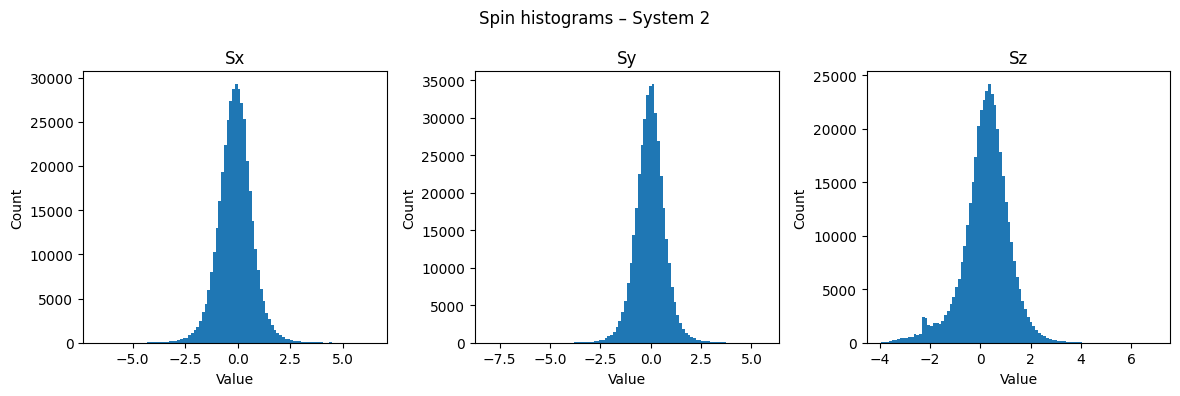

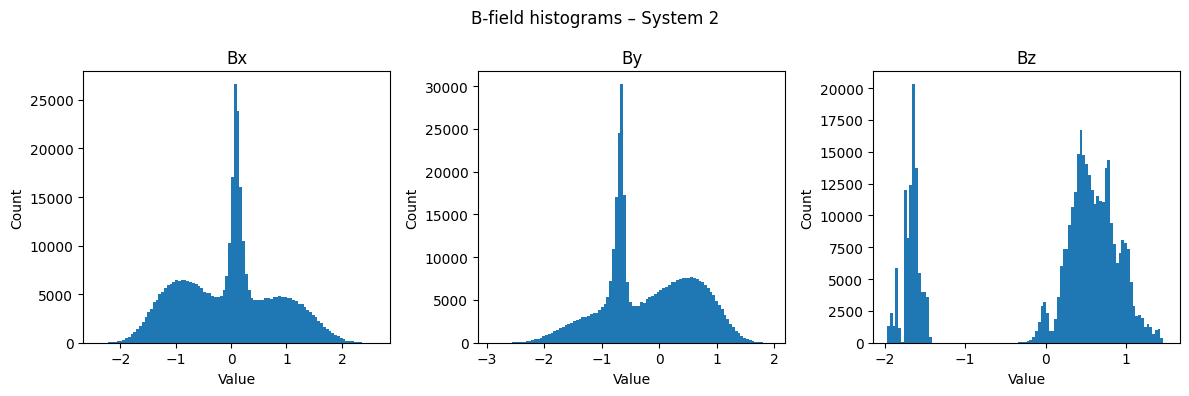

In [ ]:
from FeGdSpinGNN_NonEqui.common.utils import plot_systems_3d, plot_spin_B_histograms
plot_spin_B_histograms(train_normalized, systems=[2], bins=100)

In [13]:
import torch
from torch_geometric.data import DataLoader
batch_size = 16

train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.optim as optim
from FeGdSpinGNN_NonEqui.models.InvariantFeGdFieldModel import InvariantFeGdBFieldModel
from FeGdSpinGNN.FeGd_initialmodel import NaiveFeGdBFieldModel
import torch.nn as nn

# Initialize model
model = NaiveFeGdBFieldModel(
    node_in_dim=5,      
    hidden_dim=64,     
    num_layers=2,       
    dropout=0.2         
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
from FeGdSpinGNN_NonEqui.FeGd_trainer import BFieldTrainer, mse_loss, mae_loss, BFieldTrainerEGNN

# Create trainer
trainer = BFieldTrainerEGNN(
    model=model,
    device=device,
    loss_fn=mse_loss,
    lr=1e-4,
    use_tqdm=True
)


In [16]:
# Train the model
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    patience=5
)

Starting training
Early stopping after 5 epochs without improvement


Epoch   1/20 | Train  0.8711 | Val  0.7030 | MAE  0.6656 | MSE  0.7030 | [best]


Epoch   2/20 | Train  0.6053 | Val  0.5706 | MAE  0.5602 | MSE  0.5706 | [best]


Epoch   3/20 | Train  0.5488 | Val  0.5626 | MAE  0.5437 | MSE  0.5626 | [best]


Epoch   4/20 | Train  0.5283 | Val  0.5627 | MAE  0.5327 | MSE  0.5627 | (1/5)


Epoch   5/20 | Train  0.5175 | Val  0.5649 | MAE  0.5355 | MSE  0.5649 | (2/5)


Epoch   6/20 | Train  0.5106 | Val  0.5411 | MAE  0.5227 | MSE  0.5411 | [best]


Epoch   7/20 | Train  0.5047 | Val  0.5594 | MAE  0.5291 | MSE  0.5594 | (1/5)


Epoch   8/20 | Train  0.5002 | Val  0.5456 | MAE  0.5217 | MSE  0.5456 | (2/5)


Epoch   9/20 | Train  0.4969 | Val  0.5496 | MAE  0.5302 | MSE  0.5496 | (3/5)


Epoch  10/20 | Train  0.4943 | Val  0.5397 | MAE  0.5247 | MSE  0.5397 | [best]


Epoch  11/20 | Train  0.4917 | Val  0.5372 | MAE  0.5179 | MSE  0.5372 | [best]


Epoch  12/20 | Train  0.4881 | Val  0.5411 | MAE  0.5179 | MSE  0.5411 | (1/5)


Epoch  13/20 | Train  0.4864 | Val  0.5461 | MAE  0.5226 | MSE  0.5461 | (2/5)


Epoch  14/20 | Train  0.4843 | Val  0.5672 | MAE  0.5317 | MSE  0.5672 | (3/5)


Epoch  15/20 | Train  0.4822 | Val  0.5572 | MAE  0.5238 | MSE  0.5572 | (4/5)


Epoch  16/20 | Train  0.4809 | Val  0.5477 | MAE  0.5218 | MSE  0.5477 | (5/5)
Early stopping
Best epoch: 11
Best val loss: 0.537236


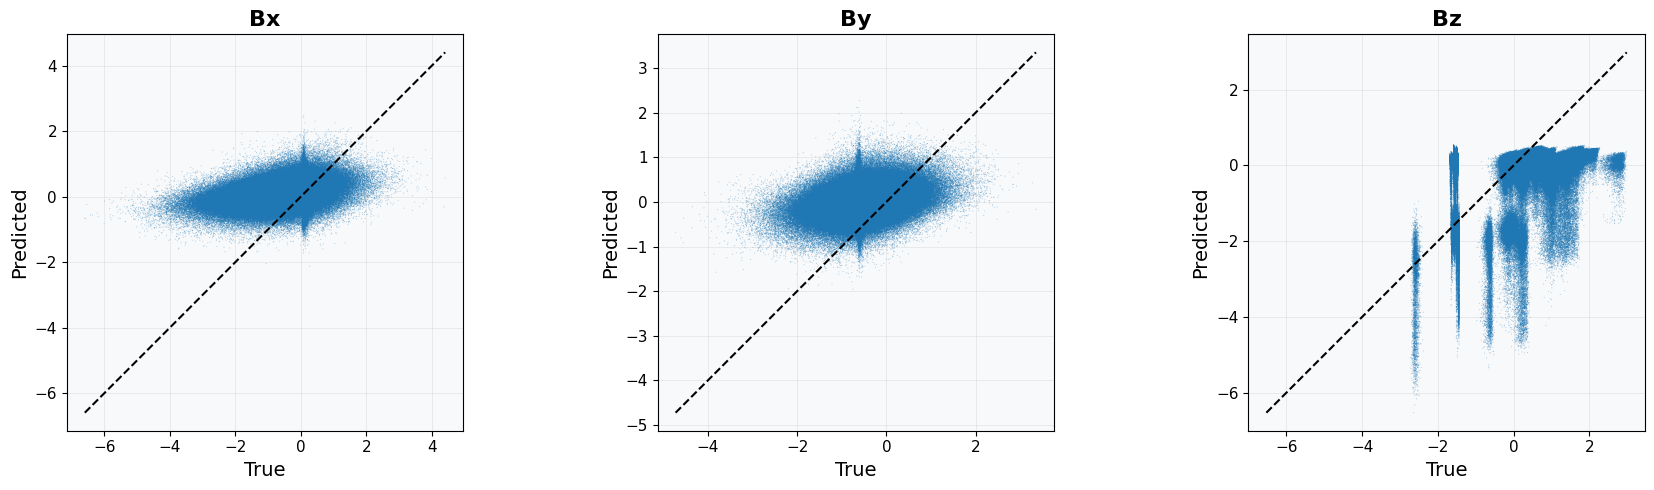


Prediction Statistics
Component    MSE          MAE          R²          
----------------------------------------------------------------------
Bx           1.1528       0.8023       -0.2941     
By           0.6528       0.6559       -0.6411     
Bz           1.6885       1.0432       -0.2651     
----------------------------------------------------------------------
Average      1.1647       0.8338       -0.4001     



In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_bfield_predictions(model, loader, device, save_path=None):
    """
    Create scatter plots for Bx, By, Bz predictions vs true values.
    
    Works with InvariantFeGdBFieldModel.
    """
    model.eval()
    
    all_preds = []
    all_targets = []
    
    print("Collecting predictions...")
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            
            # Simple forward pass - model handles everything internally
            pred = model(batch)
            
            all_preds.append(pred.cpu())
            all_targets.append(batch.y.cpu())
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    
    # Calculate metrics for each component
    mse_per_comp = np.mean((all_preds - all_targets)**2, axis=0)
    mae_per_comp = np.mean(np.abs(all_preds - all_targets), axis=0)
    r2_per_comp = []
    
    for i in range(3):
        ss_res = np.sum((all_targets[:, i] - all_preds[:, i])**2)
        ss_tot = np.sum((all_targets[:, i] - np.mean(all_targets[:, i]))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        r2_per_comp.append(r2)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    components = ['Bx', 'By', 'Bz']
    
    for i, (ax, comp) in enumerate(zip(axes, components)):
        pred_i = all_preds[:, i]
        true_i = all_targets[:, i]
        
        # Scatter plot with small points and transparency
        ax.scatter(true_i, pred_i, alpha=0.4, s=0.5, c='#1f77b4', rasterized=True, edgecolors='none')
        
        # Perfect prediction line (dashed black)
        min_val = min(true_i.min(), pred_i.min())
        max_val = max(true_i.max(), pred_i.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, zorder=10)
        
        # Set labels and title
        ax.set_xlabel('True', fontsize=14, fontweight='normal')
        ax.set_ylabel('Predicted', fontsize=14, fontweight='normal')
        ax.set_title(comp, fontsize=16, fontweight='bold')
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
        
        # Tick parameters
        ax.tick_params(labelsize=11)
        
        # Add subtle background
        ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("Prediction Statistics")
    print("="*70)
    print(f"{'Component':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-"*70)
    for i, comp in enumerate(components):
        print(f"{comp:<12} {mse_per_comp[i]:<12.4f} {mae_per_comp[i]:<12.4f} {r2_per_comp[i]:<12.4f}")
    print("-"*70)
    print(f"{'Average':<12} {np.mean(mse_per_comp):<12.4f} {np.mean(mae_per_comp):<12.4f} {np.mean(r2_per_comp):<12.4f}")
    print("="*70 + "\n")
    
    return {
        'predictions': all_preds,
        'targets': all_targets,
        'mse': mse_per_comp,
        'mae': mae_per_comp,
        'r2': r2_per_comp
    }


# Usage
results = plot_bfield_predictions(model, test_loader, device, save_path='bfield_predictions.png')

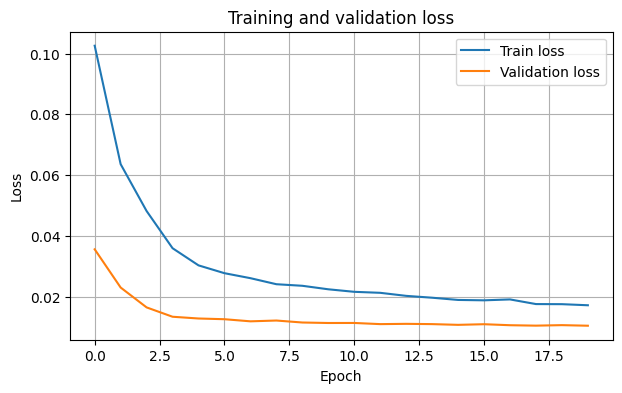

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
#Att testa:
#- Om den prediktar väl inom samma system
#- Vad som är bästa baseline av en enkel modell, testa att bygga ett invarient system
#- Bygg en modell där jag har koll på allt och där jag vet exakt vad som händer så att jag kan börja justera saker inom ett system och sedan hitta en generalisering utanför det. 